# 3D Vehicle Detection
Prediction of the bounding box and orientation of the object in 3D space from a single 2D image. 
The project is an implementation of this paper: https://arxiv.org/abs/1612.00496

## Imports

In [1]:
import os
import cv2
import sys
import json
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## Config

In [2]:
mode = 'train'
# mode = 'test'

In [3]:
if mode == 'test':
  image = './test/input' # Image path
  box2d = None # 2D detection path
  model = './model/vgg_16.ckpt' # Model path
  output = './test/output' # Output path
  
if mode == 'train':
  image = './datasets/kitti/training/image_2/' # Image path
  label = './datasets/kitti/training/label_2/' # Label path
  box2d = './datasets/kitti/training/calib/' # 2D detection path
  model = './model/vgg_16.ckpt' # Model path
  output = './datasets/kitti/validation/result' # Output path

  BIN, OVERLAP = 2, 0.1
  W = 1.
  ALPHA = 1.
  NORM_H, NORM_W = 224, 224
  VEHICLES = ['Car', 'Truck', 'Van', 'Tram','Pedestrian','Cyclist']
  learning_rate = 0.0001
  epochs = 50
  save_path = 'checkpoints/'

  dims_avg = {'Cyclist': np.array([ 1.73532436,  0.58028152,  1.77413709]), 'Van': np.array([ 2.18928571,  1.90979592,  5.07087755]), 'Tram': np.array([  3.56092896,   2.39601093,  18.34125683]), 'Car': np.array([ 1.52159147,  1.64443089,  3.85813679]), 'Pedestrian': np.array([ 1.75554637,  0.66860882,  0.87623049]), 'Truck': np.array([  3.07392252,   2.63079903,  11.2190799 ])}
  
if image is None:
    raise IOError(('Images path not found.'.format(image)))
if box2d is None :
    raise IOError(('2D bounding boxs path not found.'.format(box2d)))

if mode == 'train':
    if label is None:
        raise IOError(('Labels path not found.'.format(label)))
else:
    if model is None:
        raise IOError(('Model is not found.'.format(model)))

## Utills

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set the seeds for reproducibility
seed_value = 1234578790
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def plot_history(history):
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                             epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

def load_pretrained_model_weights(model):
  keras_model = tf.keras.applications.VGG16(weights = "imagenet")
  for keras_layer in keras_model.layers:
    weights = keras_layer.get_weights()
    if len(weights) > 0:
      our_layer = [ layer for layer in model.layers if layer.name == keras_layer.name ][0]
      our_layer.set_weights(weights)

def download_vgg_16_imagenet_weights():
  # vgg16_imagenet = tf.keras.applications.vgg16.VGG16()
  # net.set_weights(vgg16_imagenet.get_weights()[:20])
  
  net = tf.keras.applications.vgg16.VGG16()
  net.save_weights(os.path.join(save_path, 'vgg_16_imagenet', 'vgg_16.ckpt'))
  net.summary()

## Train

### └─ Loading dataset as a pipline

In [5]:
def compute_anchors(angle):
    anchors = []
    
    wedge = 2.*np.pi/BIN
    l_index = int(angle/wedge)
    r_index = l_index + 1
    
    if (angle - l_index*wedge) < wedge/2 * (1+OVERLAP/2):
        anchors.append([l_index, angle - l_index*wedge])
        
    if (r_index*wedge - angle) < wedge/2 * (1+OVERLAP/2):
        anchors.append([r_index%BIN, angle - r_index*wedge])
        
    return anchors

def parse_annotation(image_dir, label_dir):
  all_objs = []
  dims_avg = {key:np.array([0, 0, 0]) for key in VEHICLES}
  dims_cnt = {key:0 for key in VEHICLES}

  for label_file in sorted(os.listdir(label_dir)):
    image_file = label_file.replace('txt', 'png')

    for line in open(os.path.join(label_dir, label_file)).readlines():
      line = line.strip().split(' ')
      truncated = np.abs(float(line[1]))
      occluded  = np.abs(float(line[2]))

      if line[0] in VEHICLES and truncated < 0.1 and occluded < 0.1:
        new_alpha = float(line[3]) + np.pi/2.
        if new_alpha < 0:
            new_alpha = new_alpha + 2.*np.pi
        new_alpha = new_alpha - int(new_alpha/(2.*np.pi))*(2.*np.pi)

        obj = {
          'name':line[0],
          'image':image_file,
          'xmin':int(float(line[4])),
          'ymin':int(float(line[5])),
          'xmax':int(float(line[6])),
          'ymax':int(float(line[7])),
          'dims':np.array([float(number) for number in line[8:11]]),
          'new_alpha': new_alpha
        }

        dims_avg[obj['name']]  = dims_cnt[obj['name']]*dims_avg[obj['name']] + obj['dims']
        dims_cnt[obj['name']] += 1
        dims_avg[obj['name']] /= dims_cnt[obj['name']]

        all_objs.append(obj)

  # flip data
  for obj in all_objs:
    
    # Fix dimensions
    obj['dims'] = obj['dims'] - dims_avg[obj['name']]

    # Fix orientation and confidence for no flip
    orientation = np.zeros((BIN,2))
    confidence = np.zeros(BIN)

    anchors = compute_anchors(obj['new_alpha'])

    for anchor in anchors:
      orientation[anchor[0]] = np.array([np.cos(anchor[1]), np.sin(anchor[1])])
      confidence[anchor[0]] = 1.

    confidence = confidence / np.sum(confidence)

    obj['orient'] = orientation
    obj['conf'] = confidence

    # Fix orientation and confidence for flip
    orientation = np.zeros((BIN,2))
    confidence = np.zeros(BIN)

    anchors = compute_anchors(2.*np.pi - obj['new_alpha'])
    for anchor in anchors:
      orientation[anchor[0]] = np.array([np.cos(anchor[1]), np.sin(anchor[1])])
      confidence[anchor[0]] = 1

    confidence = confidence / np.sum(confidence)

    obj['orient_flipped'] = orientation
    obj['conf_flipped'] = confidence

  return all_objs

def get_source_dataset(images_folder, labels_folder):
  
  x, y = [], []
  source_dataset = parse_annotation(images_folder, labels_folder)
  
  for annotations in source_dataset:
    try:
      image_path = os.path.join(images_folder, annotations['image'])
      x.append(image_path)
      y.append(annotations) # np.array(list(annotations.items())))
    except Exception as e:
      print(e)
      
  return np.array(x), np.array(y)

In [6]:
x_data, y_data = get_source_dataset('datasets/kitti/training/image_2', 'datasets/kitti/training/label_2')

# Split original training data to sub-training (80%) and validation data (20%)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=13)

print('x_data:         ', len(x_data), 'samples')
print('y_data:         ', len(y_data), 'samples')
print('----------------------------------')
print('Train set:         ', len(y_train), 'samples')
print('Validation set:    ', len(y_val), 'samples')

x_data:          15822 samples
y_data:          15822 samples
----------------------------------
Train set:          12657 samples
Validation set:     3165 samples


In [7]:
# Prepare the training validation and test images
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(list(range(len(x_train)))))
val_dataset = tf.data.Dataset.from_tensor_slices(np.array(list(range(len(x_val)))))

### └─ Inspecting the dataset

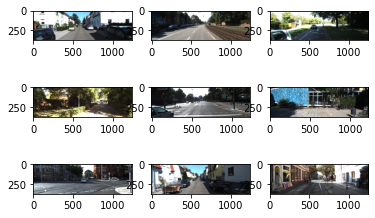

In [8]:
plt.rcParams['figure.figsize'] = [20, 10]
cnt = 1
for r in range(3):
    for c in range(3):
        idx = np.random.randint(len(x_train))
        plt.subplot(3,3,cnt)
        plt.imshow(cv2.cvtColor(cv2.imread(x_train[idx]), cv2.COLOR_BGR2RGB))
        # plt.title(y_train[idx])
        cnt = cnt + 1

### └─ Preprocessing

In [ ]:
def preprocess(*index):
  
  image_path = x_train[index]
  annotations = y_train[index]
  
  xmin = annotations['xmin']
  ymin = annotations['ymin']
  xmax = annotations['xmax']
  ymax = annotations['ymax']
  
  image = cv2.cvtColor(cv2.imread(args[0]), cv2.COLOR_BGR2RGB)
  image = image[ymin:ymax+1,xmin:xmax+1]
  image = tf.cast(image, tf.float32) / 255.0

  # flip the image
  flip = tf.random.uniform(shape=())
  if flip > 0.5: image = cv.flip(image, 1)

  # resize the image to standard size
  image = cv2.resize(image, (NORM_H, NORM_W))
  image = image - np.array([[[103.939, 116.779, 123.68]]])
  
  # Fix orientation and confidence
  if flip > 0.5:
    args = (image, [annotations['dims'], annotations['orient_flipped'], annotations['conf_flipped']])
  else:
    args = (image, [annotations['dims'], annotations['orient'], annotations['conf']])
  
  return args


train_dataset = train_dataset.map(preprocess) #, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
# train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(preprocess) #, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(64)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

### └─ Fitting

In [ ]:
def build_model():

  def orientation_loss(y_true, y_pred):
      # Find number of anchors
      anchors = tf.reduce_sum(tf.square(y_true), axis=2)
      anchors = tf.greater(anchors, tf.constant(0.5))
      anchors = tf.reduce_sum(tf.cast(anchors, tf.float32), 1)

      # Define the loss
      loss = (y_true[:,:,0]*y_pred[:,:,0] + y_true[:,:,1]*y_pred[:,:,1])
      loss = tf.reduce_sum((2 - 2 * tf.reduce_mean(loss,axis=0))) / anchors

      return tf.reduce_mean(loss)
  
  # base model
  
  Model = tf.keras.Model
  Input = tf.keras.layers.Input
  Conv2D = tf.keras.layers.Conv2D
  Dense = tf.keras.layers.Dense
  Flatten = tf.keras.layers.Flatten
  MaxPooling2D = tf.keras.layers.MaxPooling2D
  Dropout = tf.keras.layers.Dropout
  
  relu = tf.keras.activations.relu
  LeakyReLU = tf.keras.layers.LeakyReLU
  initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)
  regularizer = tf.keras.regularizers.L2(0.0005)

  inputs = Input(dtype=tf.dtypes.float32, shape=(224, 224, 3))
  d_label = Input(dtype=tf.dtypes.float32, shape=(3))
  o_label = Input(dtype=tf.dtypes.float32, shape=(BIN, 2))
  c_label = Input(dtype=tf.dtypes.float32, shape=(BIN))

  net = Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
  net = Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = MaxPooling2D(pool_size=(2, 2))(net)

  net = Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = Conv2D(128, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = MaxPooling2D(pool_size=(2, 2))(net)

  net = Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = Conv2D(256, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = MaxPooling2D(pool_size=(2, 2))(net)

  net = Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = MaxPooling2D(pool_size=(2, 2))(net)

  net = Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = Conv2D(512, kernel_size=(3, 3), padding='same', activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  net = MaxPooling2D(pool_size=(2, 2))(net)

  net = Flatten()(net)
  
  # dimensional model

  dimension = Dense(512, activation=LeakyReLU(0.1), kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  dimension = Dropout(0.5)(dimension)

  dimension = Dense(3, kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  
  d_loss = tf.keras.losses.mean_squared_error(d_label, dimension)

  # orientation model

  orientation = Dense(256, activation=LeakyReLU(0.1), kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  orientation = Dropout(0.5)(orientation)

  orientation = Dense(BIN*2, kernel_initializer=initializer, kernel_regularizer=regularizer)(orientation)
  orientation = tf.reshape(orientation, [-1, BIN, 2])
  orientation = tf.math.l2_normalize(orientation, axis=2)
  
  o_loss = orientation_loss(o_label, orientation)

  # confidence model

  confidence = Dense(256, activation=LeakyReLU(0.1), kernel_initializer=initializer, kernel_regularizer=regularizer)(net)
  confidence = Dropout(0.5)(confidence)

  confidence = Dense(BIN, kernel_initializer=initializer, kernel_regularizer=regularizer)(confidence)
  confidence = tf.nn.softmax(confidence)
  
  c_loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=c_label, logits=confidence))
  
  model = Model(inputs, [dimension, orientation, confidence])
    
  total_loss = 4. * d_loss + 8. * o_loss + c_loss
  optimizer = tf.keras.optimizers.SGD(learning_rate) #.minimize(total_loss, model.trainable_variables)

  model.compile(loss=total_loss, optimizer=optimizer, metrics=['accuracy'])

  model.summary()
  
  return model


def train(image_dir, box2d_loc, label_dir):
  
  tf.keras.backend.clear_session()
  
  model = build_model()

  # Load VGG16 imagenet pretrain weights
  vgg16_imagenet = tf.keras.applications.vgg16.VGG16()
  loaded_weights = vgg16_imagenet.trainable_variables
  for i, var in enumerate(model.trainable_variables):
    print(i+1, var.get_shape(), '==', loaded_weights[i].get_shape())
    model.trainable_variables[i] = loaded_weights[i]
  
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
  
  # Start the training
  history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
    callbacks=[checkpoint, early_stopping]
  )

## Test

In [ ]:
def test(model, image_dir, box2d_loc, box3d_loc):

    ### buile graph
    dimension, orientation, confidence, loss, optimizer, loss_d, loss_o, loss_c = build_model()

    ### GPU config 
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True
    sess = tf.Session(config=tfconfig)

    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)

    # Restore model
    saver = tf.train.Saver()
    saver.restore(sess, model)

    # create a folder for saving result
    if os.path.isdir(box3d_loc) == False:
        os.mkdir(box3d_loc)

    # Load image & run testing
    all_image = sorted(os.listdir(image_dir))

    for f in all_image:
        image_file = image_dir + f
        box2d_file = box2d_loc + f.replace('png', 'txt')
        box3d_file = box3d_loc + f.replace('png', 'txt')
        print(image_file)
        with open(box3d_file, 'w') as box3d:
            img = cv2.imread(image_file)
            img = img.astype(np.float32, copy=False)

            for line in open(box2d_file):
                line = line.strip().split(' ')
                truncated = np.abs(float(line[1]))
                occluded  = np.abs(float(line[2]))

                obj = {'xmin':int(float(line[4])),
                       'ymin':int(float(line[5])),
                       'xmax':int(float(line[6])),
                       'ymax':int(float(line[7])),
                       }

                patch = img[obj['ymin']:obj['ymax'],obj['xmin']:obj['xmax']]
                patch = cv2.resize(patch, (NORM_H, NORM_W))
                patch = patch - np.array([[[103.939, 116.779, 123.68]]])
                patch = np.expand_dims(patch, 0)
                prediction = sess.run([dimension, orientation, confidence], feed_dict={inputs: patch})
                # Transform regressed angle
                max_anc = np.argmax(prediction[2][0])
                anchors = prediction[1][0][max_anc]

                if anchors[1] > 0:
                    angle_offset = np.arccos(anchors[0])
                else:
                    angle_offset = -np.arccos(anchors[0])

                wedge = 2.*np.pi/BIN
                angle_offset = angle_offset + max_anc*wedge
                angle_offset = angle_offset % (2.*np.pi)

                angle_offset = angle_offset - np.pi/2
                if angle_offset > np.pi:
                    angle_offset = angle_offset - (2.*np.pi)

                line[3] = str(angle_offset)
                 
                line[-1] = angle_offset +np.arctan(float(line[11]) / float(line[13]))
                
                # Transform regressed dimension
                if line[0] in VEHICLES:
                    dims = dims_avg[line[0]] + prediction[0][0]
                else:
                    dims = dims_avg['Car'] + prediction[0][0]

                line = line[:8] + list(dims) + line[11:]
                
                # Write regressed 3D dim and oritent to file
                line = ' '.join([str(item) for item in line]) +' '+ str(np.max(prediction[2][0]))+ '\n'
                box3d.write(line)

## Main

In [ ]:
if mode == 'train':
  train(image, box2d, label)
elif mode == 'test':
  test(model, image, box2d, output)